<a href="https://colab.research.google.com/github/YoshiakiAsahara/for-intern/blob/main/phase1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**データを整理・集計・可視化**

In [1]:
#ライブラリインポート
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#データダウンロード
account_df = pd.read_csv('/content/drive/MyDrive/account.csv',encoding='UTF-8')
order_df = pd.read_csv('/content/drive/MyDrive/order.csv',encoding='UTF-8')
personnel_df = pd.read_csv('/content/drive/MyDrive/personnel_expenses.csv',encoding='UTF-8')

**データ前処理（月次・曜日集計・結合用の前処理）**

In [165]:
#決済データに対し、結合・集計用(月次・曜日）前処理を行う
account_df['日付'] =pd.to_datetime(account_df['日付'])
account_df['月'] = account_df['日付'].dt.strftime('%Y%m')
account_df['曜日'] = account_df['日付'].dt.strftime('%A')
#人件費データに対し、結合・集計用前処理を行う
personnel_df.rename(columns={'出勤日':'日付'},inplace=True)
personnel_df['日付'] =pd.to_datetime(personnel_df['日付'])
personnel_df['月'] = personnel_df['日付'].dt.strftime('%Y%m')
personnel_df['曜日'] = personnel_df['日付'].dt.strftime('%A')

**営業利益の月次集計**

In [166]:
#月次集計用に、決済データの販売月時をオーダーデータに結合
df = pd.merge(order_df,account_df[['決済ID','月']],on='決済ID',how = 'inner')
#人件費の月次データを集計
month_personnel_df = personnel_df.groupby('月').人件費合計.sum().reset_index()
#売上高を月次集計
month_df = df.groupby(['月']).総売上高.sum().reset_index()
#月毎に固定費・変動費を計上
month_df['固定費'] = 330000
month_df['変動費'] = month_df['総売上高']*0.1
#人件費データを結合・月次データを作成
month_df = pd.merge(month_df,month_personnel_df,on='月',how='inner')
#月次営業利益を計算(総売上高から販売管理費を引く)
month_df['営業利益'] = month_df['総売上高'] - (month_df['固定費'] + month_df['変動費'] + month_df['人件費合計'])

In [167]:
#月次サマリデータを作成
month_all_df = pd.DataFrame(month_df[['月','総売上高','営業利益','人件費合計']])

**粗利の月次集計**

In [168]:
#カテゴリ別総売上高を月次集計
category_sales_amount =df.groupby(['月','カテゴリ']).総売上高.sum().unstack()
#原価率35%のフード・ワインと原価率25%のカテゴリに分けて月次合計額を計算
food_win_bene_month_df = category_sales_amount[['フード','ワイン']].reset_index()
other_bene_month_df = category_sales_amount[['その他','コーヒー','デザート','ドリンク']].reset_index()
#原価を計算
food_win_bene_month_df['35Cost'] =food_win_bene_month_df[['フード','ワイン']].sum(axis=1)*0.35
other_bene_month_df['25Cost'] =other_bene_month_df[['その他','コーヒー','デザート','ドリンク']].sum(axis=1)*0.35
#原価を一つのDFに結合
cost_month_df =pd.merge(food_win_bene_month_df[['35Cost','月']],other_bene_month_df[['25Cost','月']],on='月',how='inner')
#原価合計額を計算
cost_month_df['原価']=cost_month_df[['35Cost','25Cost']].sum(axis=1)

In [169]:
#月次サマリデータに原価データを結合
month_all_df = pd.merge(month_all_df,cost_month_df[['月','原価']], on='月',how='inner')

In [170]:
#サマリデータで粗利を計算
month_all_df['粗利'] = month_all_df['総売上高'] - month_all_df['原価']

**顧客数の月次集計**

In [171]:
#大人と子供の数を月次に集計
month_customer_df = account_df.groupby('月').agg({'大人': np.sum,'子供': np.sum})
#顧客合計を算出
month_customer_df['顧客合計'] = month_customer_df['大人'] + month_customer_df['子供']

In [172]:
#月次サマリデータを作成
month_all_df = pd.merge(month_all_df,month_customer_df,on='月',how='inner')

**顧客単価の月次集計**

In [173]:
#顧客単価を計算
month_all_df['顧客単価'] = np.round(month_all_df['総売上高'] / month_all_df['顧客合計'])

**アンケート回答率・リピート率の月次集計**

In [174]:
#アンケートカテゴリ別データを月次で集計
ank_month_df = account_df.groupby(['来店数アンケート','月']).来店数アンケート.count().unstack()
#月次アンケート回答率・リピート率を作成
month_ank_rate_df = np.round((ank_month_df.loc[1] + ank_month_df.loc[2]) / (ank_month_df.loc[0]+ank_month_df.loc[1]+ank_month_df.loc[2]),4)*100
month_repeat_rate_df = np.round((ank_month_df.loc[2] / (ank_month_df.loc[1] + ank_month_df.loc[2])),3)*100
#結合用前処理
month_ank_rate_df.rename('回答率',inplace=True)
month_ank_rate_df = month_ank_rate_df.reset_index()
month_repeat_rate_df.rename('リピート率',inplace=True)
month_repeat_rate_df = month_repeat_rate_df.reset_index()
#回答率とリピート率を結合
month_result_df = pd.merge(month_repeat_rate_df,month_ank_rate_df,on='月',how='inner')

In [175]:
#サマリデータに月次回答率とリピート率を結合
month_all_df = pd.merge(month_all_df,month_result_df)

**グループ単位滞在時間の月次集計**

In [176]:
account_df['決済ID'].count()

6757

In [177]:
#月毎に総滞在時間集計
stay_time_month = account_df.groupby('月').滞在時間.mean().reset_index()

In [178]:
#サマリデータに結合
month_all_df = pd.merge(month_all_df,stay_time_month,on='月',how='inner')

**月次サマリデータの完成**

In [179]:
month_all_df

,月,総売上高,営業利益,人件費合計,原価,粗利,大人,子供,顧客合計,顧客単価,リピート率,回答率,滞在時間
0,202208,1063976,-102223.6,729802,372391.60,691584.40,649,82,731,1456.0,19.7,34.08,1.225475
1,202209,1500133,220831.7,799288,525046.55,975086.45,939,94,1033,1452.0,16.6,37.17,1.256858
2,202210,1528823,404752.7,641188,535088.05,993734.95,939,94,1033,1480.0,15.7,34.56,1.248835
3,202211,1640478,522242.2,624188,574167.30,1066310.70,886,78,964,1702.0,22.8,36.56,1.312863
4,202212,1319494,304503.6,553041,461822.90,857671.10,757,58,815,1619.0,24.0,33.49,1.296353
5,202301,1359911,447368.9,446551,475968.85,883942.15,808,68,876,1552.0,16.9,33.71,1.258747
6,202302,1554255,613762.5,455067,543989.25,1010265.75,932,84,1016,1530.0,20.1,37.20,1.227925
7,202303,2180410,1012189.0,620180,763143.50,1417266.50,1225,117,1342,1625.0,21.4,35.12,1.295116
8,202304,2215913,1049486.7,614835,775569.55,1440343.45,1207,135,1342,1651.0,15.3,35.33,1.260509
9,202305,2594797,1462226.3,543091,908178.95,1686618.05,1380,130,1510,1718.0,22.6,35.62,1.277567


**商品カテゴリ別の月次売上**

In [180]:
#月次集計のためデータ結合
month_category_sales =  pd.merge(order_df,account_df[['決済ID','月']],how='inner',on='決済ID')
#カテゴリ別総売上高月次集計
month_category_sales_df =month_category_sales.groupby(['カテゴリ','月']).agg({'総売上高':np.sum}).unstack()
#グラフ表示のため、英名に変換
index_dict = {'その他': 'Others', 'コーヒー': 'Coffee', 'デザート': 'Dessert', 'ドリンク': 'Drink', 'フード': 'Food', 'ワイン': 'Wine'}
month_category_sales_df.index = month_category_sales_df.index.map(index_dict)

In [181]:
month_category_sales_df

総売上高                                                           \
月        202208  202209  202210  202211  202212  202301  202302   202303   
カテゴリ                                                                       
Others    13040   27472   25963  251953  137541  151334  107986   129965   
Coffee   125216  202224  183807  148875  118426  143340  177677   214413   
Dessert   79353  130231  131831  104824  105846  113995  129019   162709   
Drink    187954  161451   82675   69725   44227   68010   65987    88390   
Food     605704  843977  946425  934525  656979  699642  951709  1367169   
Wine      52709  134778  158122  130576  256475  183590  121877   217764   

                                             
月         202304   202305   202306   202307  
カテゴリ                                         
Others    117572   203980   479032   134400  
Coffee    199315   210499   131101   120904  
Dessert   167598   207517   130030   146310  
Drink     204455   395038   350983   297956  
Food     1249899  1335383  1188974  1024984  
Wine      277074   242380   197199   148089

**カテゴリ別注文率の月次集計**

In [182]:
#月次集計のためデータ結合
month_category_df = pd.merge(order_df,account_df[['決済ID','月']],how='inner',on='決済ID')
#カテゴリ別注文数月次集計
month_rate_category_df = month_category_df.groupby(['月','カテゴリ']).agg({'数量':np.sum}).unstack()
# 各月の合計を計算
month_rate_category_df['合計'] = month_rate_category_df.sum(axis=1)
# 各カテゴリの注文率を計算
for category in month_rate_category_df.columns[:-1]:  # 合計列を除外します
    month_rate_category_df[f'{category}_注文率'] = month_rate_category_df[category] / month_rate_category_df['合計']
#注文率を取り出す
result_month_rate_category_df =pd.DataFrame(np.round(month_rate_category_df.iloc[:,7:],3)*100)
result_month_rate_category_df.columns = ['Others', 'Coffee', 'Dessert', 'Drink', 'Food', 'Wine']

In [183]:
result_month_rate_category_df

,Others,Coffee,Dessert,Drink,Food,Wine
月,,,,,,
202208,0.9,18.6,10.7,23.5,43.1,3.1
202209,1.4,22.2,12.6,16.1,42.4,5.3
202210,1.4,18.2,11.7,7.5,54.9,6.3
202211,7.0,14.6,9.6,6.4,57.8,4.7
202212,13.9,13.4,11.1,4.8,46.7,10.0
202301,10.1,16.0,11.8,7.1,48.7,6.3
202302,4.6,17.6,11.7,6.3,55.4,4.3
202303,3.2,15.6,11.0,6.2,58.4,5.6
202304,3.9,14.0,11.1,16.2,47.8,7.0


**顧客単価・顧客数（大人・子供・顧客合計）の曜日別集計**

In [184]:
#曜日別集計用に、決済データの販売曜日をオーダーデータに結合
df_weekly = pd.merge(order_df,account_df[['決済ID','曜日','大人','子供']],on='決済ID',how = 'inner')
#曜日別総売上高を計算
weekly_sales_df = df_weekly.groupby('曜日').総売上高.sum().reset_index()

In [185]:
#曜日サマリデータを作成
weekly_all_df = pd.DataFrame(weekly_sales_df)

In [186]:
#大人と子供の数を曜日別に集計
weekly_customer_df = account_df.groupby('曜日').agg({'大人': np.sum,'子供': np.sum}).reset_index()
#顧客合計を算出
weekly_customer_df['顧客合計'] = weekly_customer_df['大人'] + weekly_customer_df['子供']

In [187]:
#曜日サマリデータに結合
weekly_all_df = pd.merge(weekly_all_df,weekly_customer_df,on='曜日',how='inner')

In [188]:
#曜日別顧客単価を算出
weekly_all_df['顧客単価'] = np.round(weekly_all_df['総売上高'] / weekly_all_df['顧客合計'])

**アンケート回答率の曜日別集計**

In [189]:
# アンケートカテゴリ別データを週次で集計
ank_weekly_df = account_df.groupby(['来店数アンケート','曜日']).来店数アンケート.count()
# 曜日別アンケート回答率・リピート率を作成
weekly_ank_rate_df = np.round((ank_weekly_df.loc[1] + ank_weekly_df.loc[2]) / (ank_weekly_df.loc[0]+ank_weekly_df.loc[1]+ank_weekly_df.loc[2]),4)*100
weekly_repeat_rate_df = np.round((ank_weekly_df.loc[2] / (ank_weekly_df.loc[1] + ank_weekly_df.loc[2])),3)*100
# 結合用前処理
weekly_ank_rate_df.rename('回答率',inplace=True)
weekly_ank_rate_df = weekly_ank_rate_df.reset_index()
weekly_repeat_rate_df.rename('リピート率',inplace=True)
weekly_repeat_rate_df = weekly_repeat_rate_df.reset_index()
# 回答率とリピート率を結合
weekly_result_df = pd.merge(weekly_repeat_rate_df, weekly_ank_rate_df, on='曜日', how='inner')

In [190]:
#曜日別サマリデータに回答率とリピート率を結合
weekly_all_df = pd.merge(weekly_all_df,weekly_result_df,on='曜日',how='inner')

**滞在時間の曜日別集計**

In [191]:
#曜日毎に集計
stay_time_weekly = account_df.groupby('曜日').滞在時間.mean().reset_index()

In [192]:
#曜日サマリデータに結合
weekly_all_df = pd.merge(weekly_all_df,stay_time_weekly,on='曜日',how='inner')

**曜日サマリデータの完成**

In [193]:
weekly_all_df

,曜日,総売上高,大人,子供,顧客合計,顧客単価,リピート率,回答率,滞在時間
0,Friday,2390484,1392,89,1481,1614.0,30.8,35.95,1.382687
1,Monday,346335,158,31,189,1832.0,34.8,30.26,1.370132
2,Saturday,4375162,2544,301,2845,1538.0,8.4,35.90,1.155081
3,Sunday,6357838,3601,519,4120,1543.0,9.9,34.76,1.133064
4,Thursday,3108407,1783,103,1886,1648.0,26.5,37.49,1.377498
5,Tuesday,1847231,1030,55,1085,1703.0,24.9,35.09,1.368880
6,Wednesday,2882695,1631,97,1728,1668.0,27.5,36.84,1.382490


**商品カテゴリ別の曜日別売上**

In [194]:
# 曜日別集計のためデータ結合
weekly_category_sales = pd.merge(order_df, account_df[['決済ID', '曜日']], how='inner', on='決済ID')
# カテゴリ別総売上高を曜日別に集計
weekly_category_sales_df = weekly_category_sales.groupby(['カテゴリ', '曜日']).agg({'総売上高': np.sum}).unstack()
# グラフ表示のため、英名に変換
index_dict = {'その他': 'Others', 'コーヒー': 'Coffee', 'デザート': 'Dessert', 'ドリンク': 'Drink', 'フード': 'Food', 'ワイン': 'Wine'}
weekly_category_sales_df.index = weekly_category_sales_df.index.map(index_dict)

In [195]:
weekly_category_sales_df

総売上高                                                      
曜日        Friday  Monday Saturday   Sunday Thursday  Tuesday Wednesday
カテゴリ                                                                  
Others    102356   56803   174068   842193   342522    79976    182320
Coffee    256381   23357   425357   546932   317521   153811    252438
Dessert   209691   22424   345164   443855   252339   118342    217448
Drink     248562   42752   461596   524964   280904   201367    256706
Food     1401060  162858  2503243  3362655  1595554  1086658   1693342
Wine      172434   38141   465734   637239   319567   207077    280441

**商品カテゴリ別の曜日別注文率**

In [196]:
# 週次集計のためデータ結合
weekly_category_df = pd.merge(order_df, account_df[['決済ID', '曜日']], how='inner', on='決済ID')
# カテゴリ別注文数曜日別集計
weekly_rate_category_df = weekly_category_df.groupby(['曜日', 'カテゴリ']).agg({'数量': np.sum}).unstack()
# 各曜日の合計を計算
weekly_rate_category_df['合計'] = weekly_rate_category_df.sum(axis=1)
# 各カテゴリの注文率を計算
for category in weekly_rate_category_df.columns[:-1]:  # 合計列を除外します
    weekly_rate_category_df[f'{category}_注文率'] = weekly_rate_category_df[category] / weekly_rate_category_df['合計']
# 注文率を取り出す
result_weekly_rate_category_df = pd.DataFrame(np.round(weekly_rate_category_df.iloc[:, 7:], 3)*100)
result_weekly_rate_category_df.columns = ['Others', 'Coffee', 'Dessert', 'Drink', 'Food', 'Wine']

In [197]:
result_weekly_rate_category_df

,Others,Coffee,Dessert,Drink,Food,Wine
曜日,,,,,,
Friday,4.3,16.3,12.1,16.6,46.4,4.3
Monday,1.5,12.2,10.5,22.4,46.5,7.0
Saturday,3.7,15.0,11.1,17.2,47.0,6.0
Sunday,8.0,14.0,10.5,14.0,48.0,5.6
Thursday,5.6,16.5,11.8,15.2,44.5,6.4
Tuesday,2.8,13.1,9.3,19.7,48.8,6.3
Wednesday,5.5,13.7,10.8,15.2,49.2,5.8


**経営指標の月毎の推移**

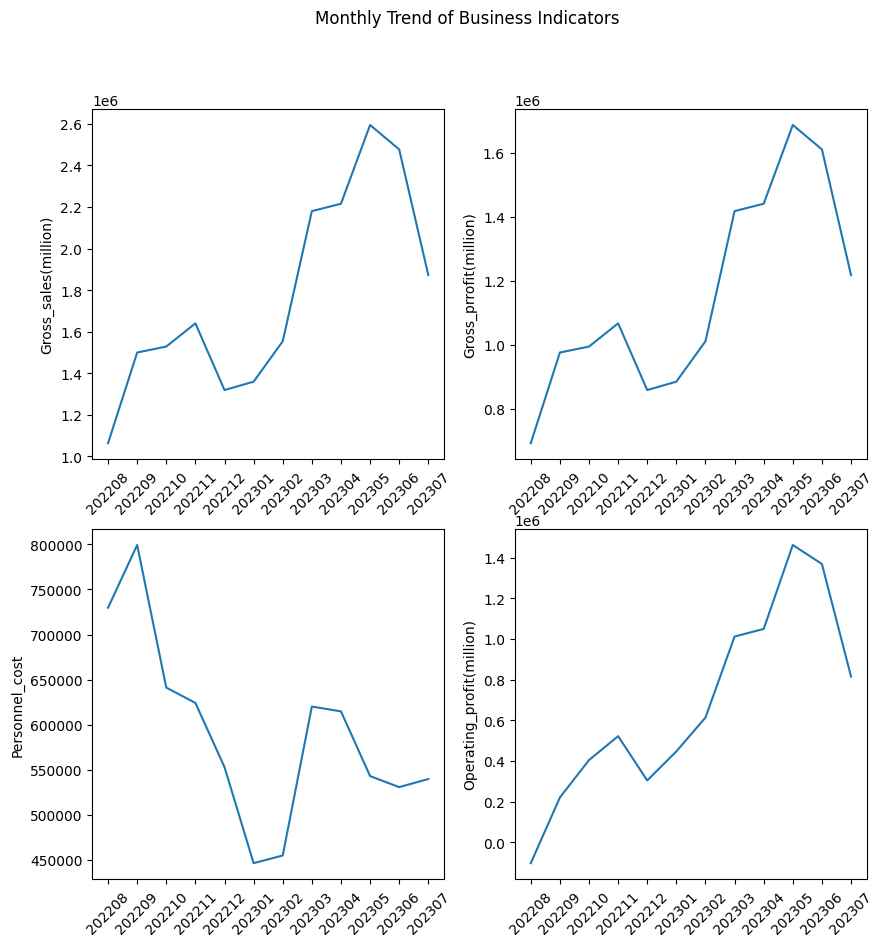

In [198]:
# 2x2のグリッドを作成
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
#売り上げの推移をプロット
sns.lineplot(x='月',y='総売上高',data = month_all_df, ax=axs[0,0])
axs[0,0].set_xticks(axs[0,0].get_xticks())
axs[0,0].set_xticklabels(axs[0,0].get_xticklabels(), rotation=45)
axs[0,0].set_ylabel('Gross_sales(million)')
axs[0,0].set_xlabel('')
#粗利の推移をプロット
sns.lineplot(x='月',y='粗利',data = month_all_df, ax=axs[0,1])
axs[0,1].set_xticks(axs[0,0].get_xticks())
axs[0,1].set_xticklabels(axs[0,0].get_xticklabels(), rotation=45)
axs[0,1].set_ylabel('Gross_prrofit(million)')
axs[0,1].set_xlabel('')
#人件費の推移をプロット
sns.lineplot(x='月',y='人件費合計',data = month_all_df, ax=axs[1,0])
axs[1,0].set_xticks(axs[0,0].get_xticks())
axs[1,0].set_xticklabels(axs[0,0].get_xticklabels(), rotation=45)
axs[1,0].set_ylabel('Personnel_cost')
axs[1,0].set_xlabel('')
#営業利益の推移をプロット
sns.lineplot(x='月',y='営業利益',data = month_all_df, ax=axs[1,1])
axs[1,1].set_xticks(axs[0,0].get_xticks())
axs[1,1].set_xticklabels(axs[0,0].get_xticklabels(), rotation=45)
axs[1,1].set_ylabel('Operating_profit(million)')
axs[1,1].set_xlabel('')
#グラフにタイトルを追加
plt.suptitle('Monthly Trend of Business Indicators');

**カテゴリ別に売上集計**

In [199]:
#カテゴリ別集計
category_sales = df.groupby('カテゴリ').agg({'総売上高':np.sum})
#グラフ表示の英名に変換
index_dict = {'その他': 'Others', 'コーヒー': 'Coffee', 'デザート': 'Dessert', 'ドリンク': 'Drink', 'フード': 'Food', 'ワイン': 'Wine'}
category_sales.index = category_sales.index.map(index_dict)

**カテゴリ別売上の可視化**

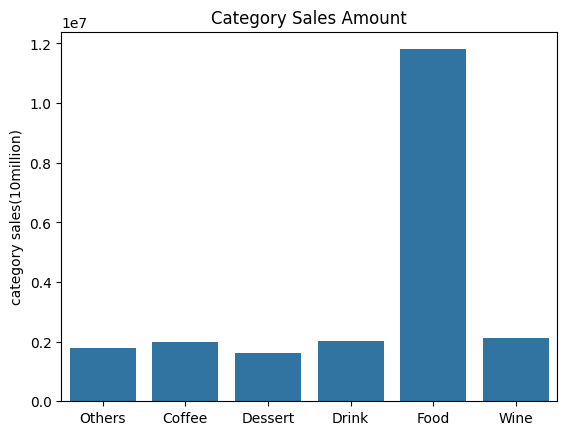

In [200]:
#カテゴリ別売上の可視化
sns.barplot(x='カテゴリ',y='総売上高',data=category_sales)
plt.ylabel('category sales(10million)')
plt.xlabel('')
plt.title('Category Sales Amount');

**カテゴリ別注文率の可視化**

Text(0.5, 1.0, 'Category_Rate_of_Order(%)')

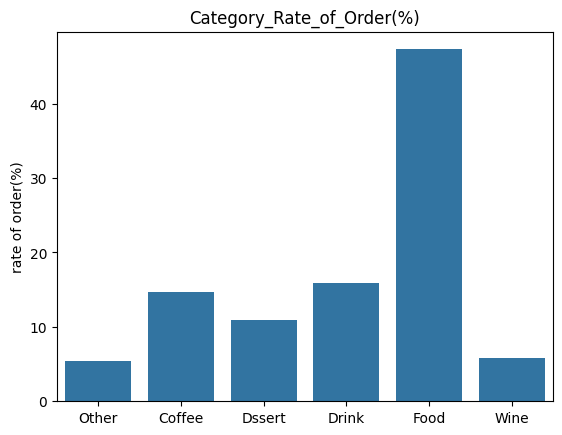

In [201]:
#カテゴリ別注文率の可視化
sns.barplot(x='カテゴリ',y='注文率',data=rate_category_tmp.reset_index())
plt.xlabel('')
plt.ylabel('rate of order(%)')
plt.title('Category_Rate_of_Order(%)')

**顧客単価・各顧客数（合計・大人・子供）の月次推移**

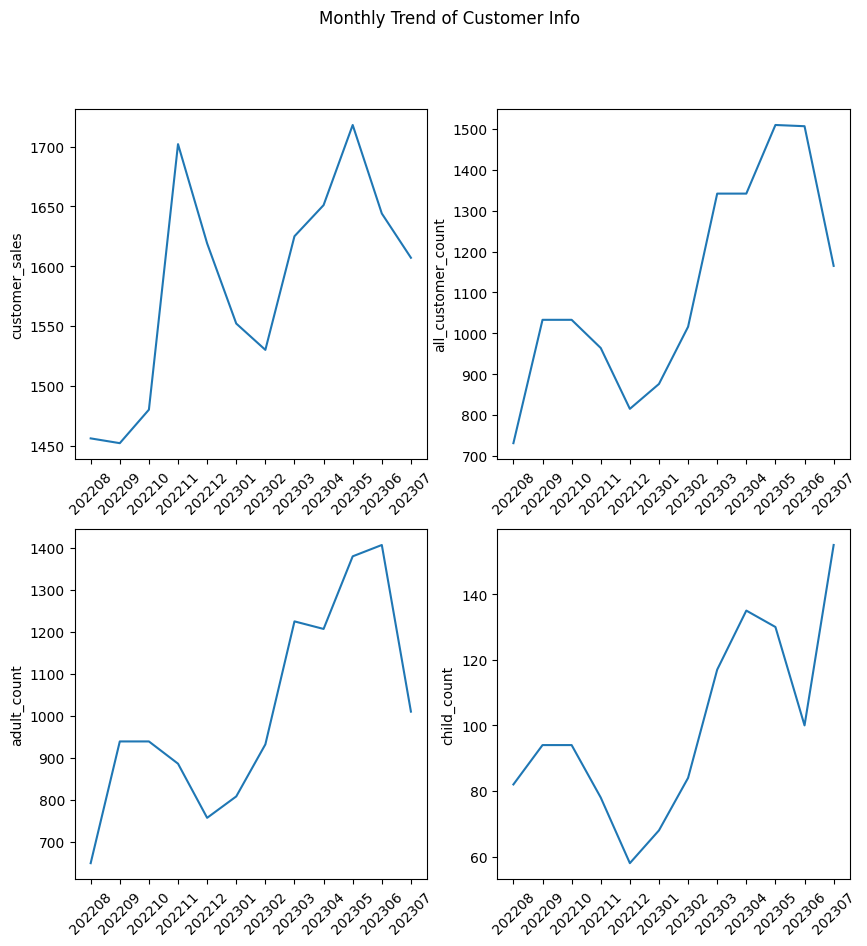

In [202]:
# 2x2のグリッドを作成
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
#顧客単価の推移
sns.lineplot(x='月',y='顧客単価',data=month_all_df,ax=axs[0,0])
axs[0,0].set_xticks(axs[0,0].get_xticks())
axs[0,0].set_xticklabels(axs[0,0].get_xticklabels(), rotation=45)
axs[0,0].set_ylabel('customer_sales')
axs[0,0].set_xlabel('')
#顧客数をプロット
sns.lineplot(x='月',y='顧客合計',data = month_all_df, ax=axs[0,1])
axs[0,1].set_xticks(axs[0,1].get_xticks())
axs[0,1].set_xticklabels(axs[0,1].get_xticklabels(), rotation=45)
axs[0,1].set_ylabel('all_customer_count')
axs[0,1].set_xlabel('')
#人件費の推移をプロット
sns.lineplot(x='月',y='大人',data = month_all_df, ax=axs[1,0])
axs[1,0].set_xticks(axs[1,0].get_xticks())
axs[1,0].set_xticklabels(axs[1,0].get_xticklabels(), rotation=45)
axs[1,0].set_ylabel('adult_count')
axs[1,0].set_xlabel('')
#純利益の推移をプロット
sns.lineplot(x='月',y='子供',data = month_all_df, ax=axs[1,1])
axs[1,1].set_xticks(axs[1,1].get_xticks())
axs[1,1].set_xticklabels(axs[1,1].get_xticklabels(), rotation=45)
axs[1,1].set_ylabel('child_count')
axs[1,1].set_xlabel('')
plt.suptitle('Monthly Trend of Customer Info');

**アンケート回答率・リピート率の月次推移**

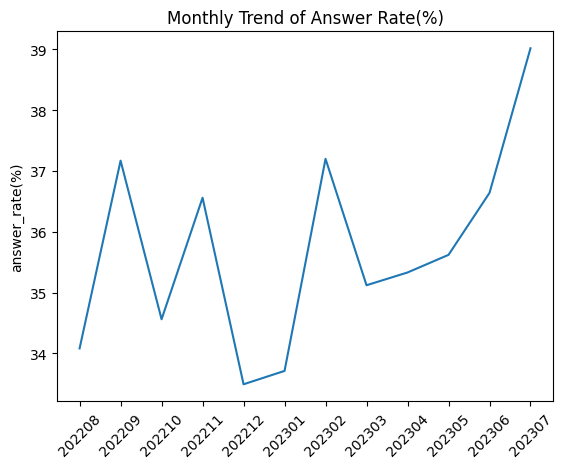

In [203]:
#アンケート回答率の月次データ可視化
sns.lineplot(x='月',y='回答率',data=month_all_df)
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('answer_rate(%)')
plt.title('Monthly Trend of Answer Rate(%)');

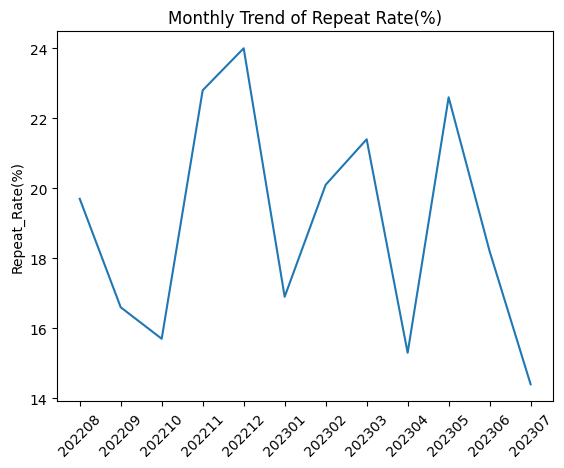

In [204]:
#リピート率のデータ可視化
#アンケート回答率の月次データ可視化
sns.lineplot(x='月',y='リピート率',data=month_all_df)
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('Repeat_Rate(%)')
plt.title('Monthly Trend of Repeat Rate(%)');

**滞在時間の月次推移**

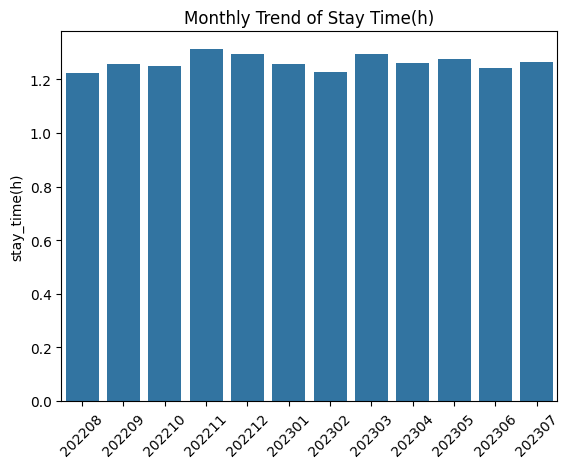

In [205]:
#滞在時間の月次データ可視化
sns.barplot(x='月',y='滞在時間',data=month_all_df)
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('stay_time(h)')
plt.title('Monthly Trend of Stay Time(h)');

**カテゴリ別売上の月次推移**

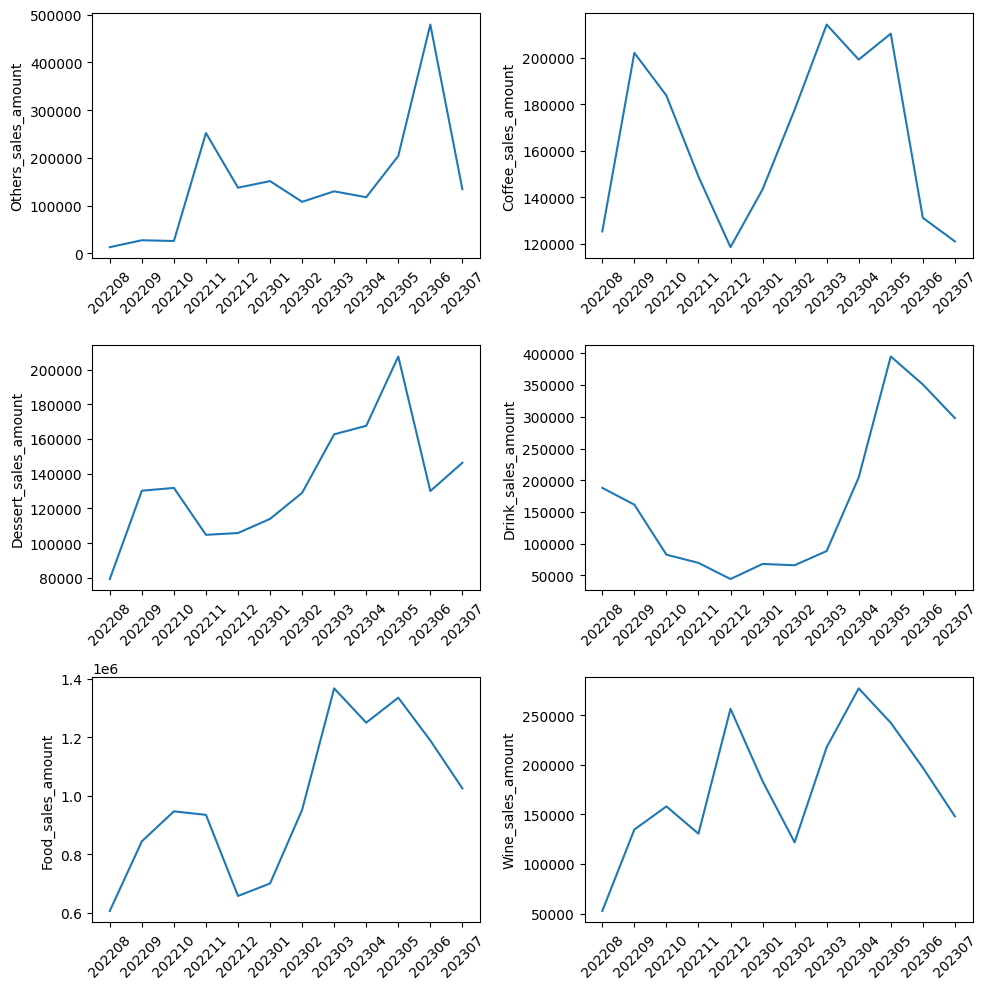

In [206]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
categories = ['Others', 'Coffee', 'Dessert', 'Drink', 'Food', 'Wine']
english_labels = ['Others', 'Coffee', 'Dessert', 'Drink', 'Food', 'Wine']
#インデックスとカテゴリを取り出す
for i, category in enumerate(categories):
    row = i // 2
    col = i % 2
    sns.lineplot(x='月', y=category, data=month_category_sales_df.loc[category].reset_index(), ax=axs[row, col])
    axs[row, col].set_xlabel('')
    axs[row, col].set_ylabel(english_labels[i] + '_sales_amount')
    axs[row, col].set_xticks(axs[row, col].get_xticks())
    axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

**カテゴリ別注文率の月次推移**

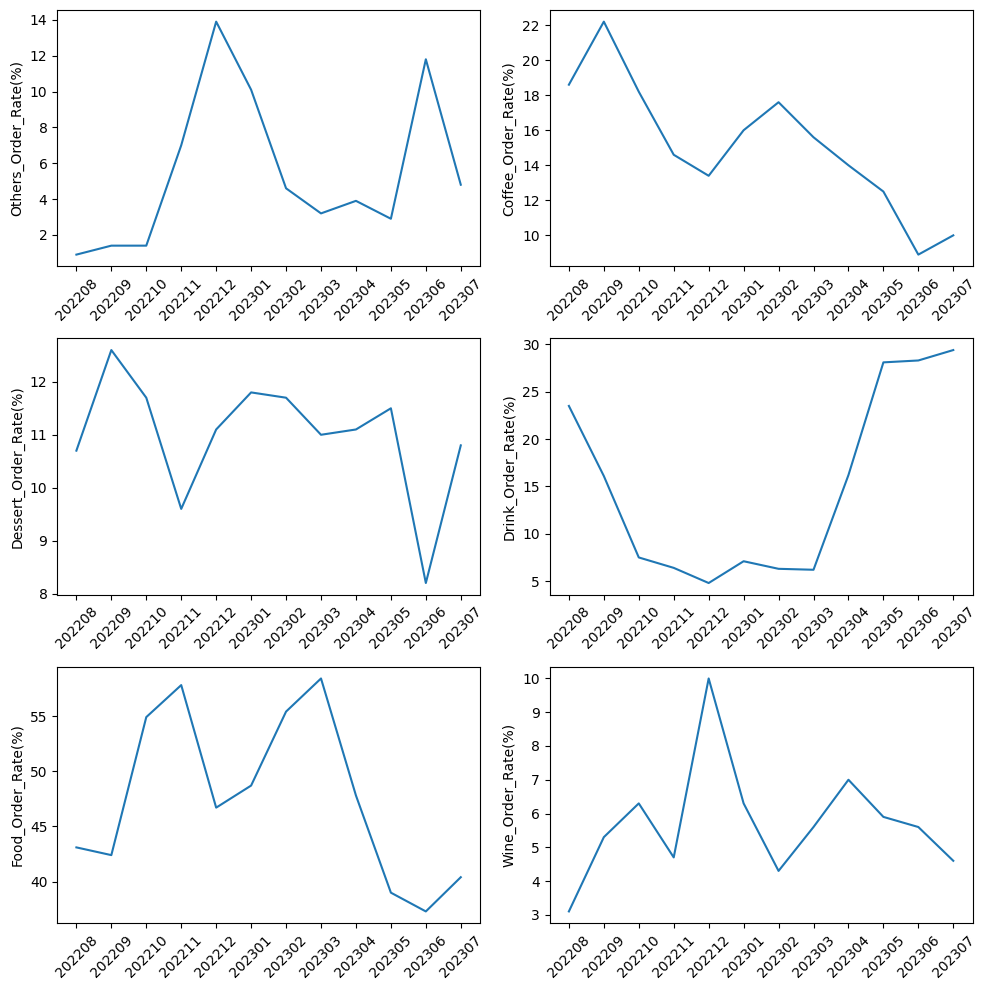

In [207]:
categories = ['Others', 'Coffee', 'Dessert', 'Drink', 'Food', 'Wine']
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
for i, category in enumerate(categories):
    row = i // 2
    col = i % 2
    sns.lineplot(x='月', y=category, data=result_month_rate_category_df[category].reset_index(), ax=axs[row, col])
    axs[row, col].set_xlabel('')
    axs[row, col].set_ylabel(categories[i] + '_Order_Rate(%)')
    axs[row, col].set_xticks(axs[row, col].get_xticks())
    axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

**顧客単価・顧客数（大人・子供。顧客合計）の曜日別傾向**

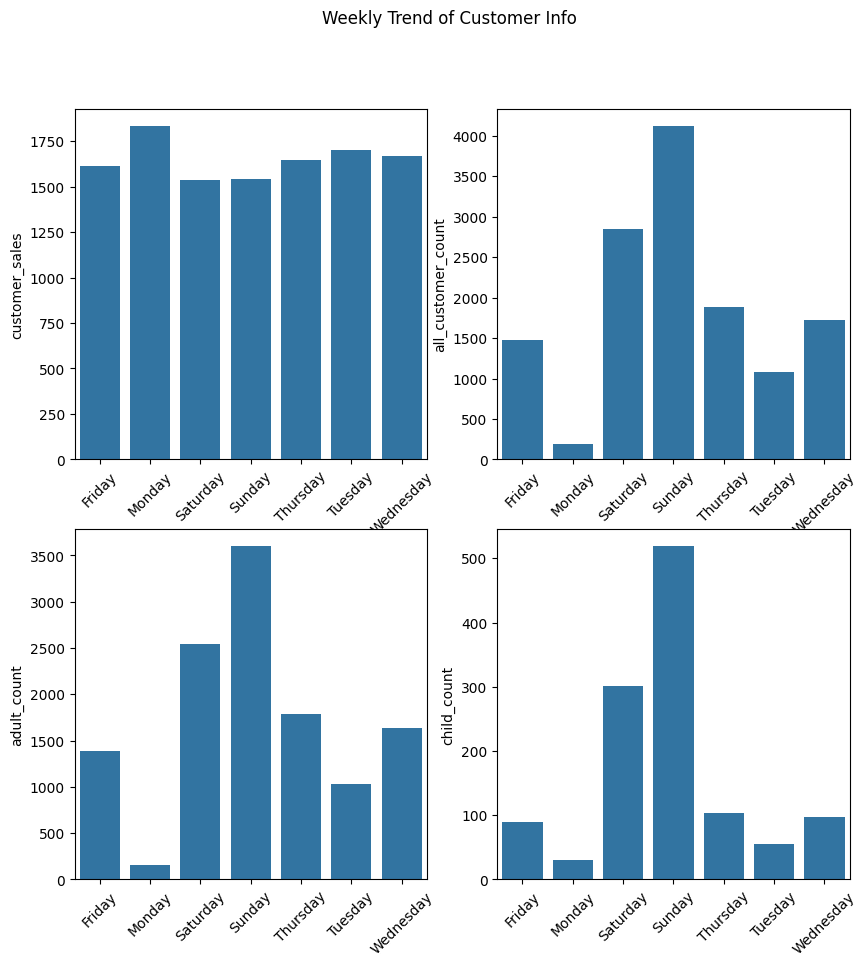

In [208]:
# 2x2のグリッドを作成
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
#顧客単価の推移
sns.barplot(x='曜日',y='顧客単価',data=weekly_all_df,ax=axs[0,0])
axs[0,0].set_xticks(axs[0,0].get_xticks())
axs[0,0].set_xticklabels(axs[0,0].get_xticklabels(), rotation=45)
axs[0,0].set_ylabel('customer_sales')
axs[0,0].set_xlabel('')
#顧客数をプロット
sns.barplot(x='曜日',y='顧客合計',data = weekly_all_df, ax=axs[0,1])
axs[0,1].set_xticks(axs[0,1].get_xticks())
axs[0,1].set_xticklabels(axs[0,1].get_xticklabels(), rotation=45)
axs[0,1].set_ylabel('all_customer_count')
axs[0,1].set_xlabel('')
#人件費の推移をプロット
sns.barplot(x='曜日',y='大人',data = weekly_all_df, ax=axs[1,0])
axs[1,0].set_xticks(axs[1,0].get_xticks())
axs[1,0].set_xticklabels(axs[1,0].get_xticklabels(), rotation=45)
axs[1,0].set_ylabel('adult_count')
axs[1,0].set_xlabel('')
#純利益の推移をプロット
sns.barplot(x='曜日',y='子供',data = weekly_all_df, ax=axs[1,1])
axs[1,1].set_xticks(axs[1,1].get_xticks())
axs[1,1].set_xticklabels(axs[1,1].get_xticklabels(), rotation=45)
axs[1,1].set_ylabel('child_count')
axs[1,1].set_xlabel('')
plt.suptitle('Weekly Trend of Customer Info');

**アンケート回答率・リピート率曜日別傾向**

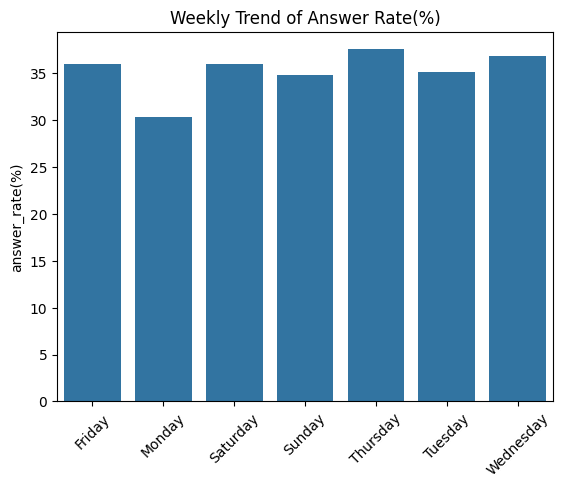

In [209]:
#アンケート回答率の曜日別データ可視化
sns.barplot(x='曜日',y='回答率',data=weekly_all_df)
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('answer_rate(%)')
plt.title('Weekly Trend of Answer Rate(%)');

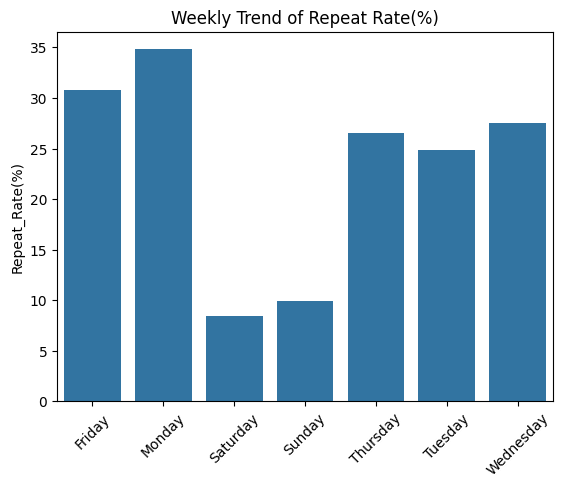

In [210]:
#リピート率のデータ可視化
#アンケート回答率の曜日別データ可視化
sns.barplot(x='曜日',y='リピート率',data=weekly_all_df)
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('Repeat_Rate(%)')
plt.title('Weekly Trend of Repeat Rate(%)');

**滞在時間の曜日別傾向**

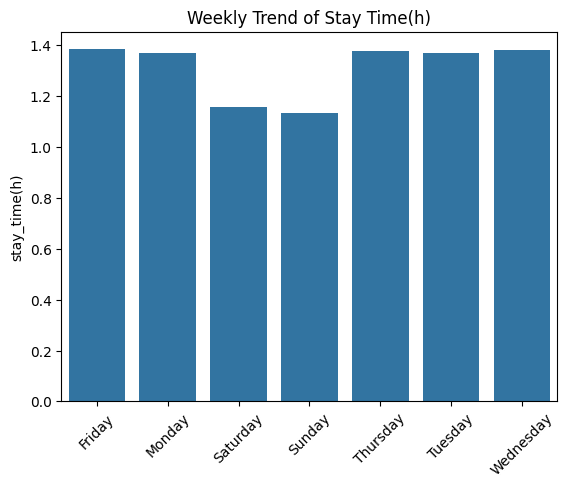

In [211]:
#滞在時間の月次データ可視化
sns.barplot(x='曜日',y='滞在時間',data=weekly_all_df)
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('stay_time(h)')
plt.title('Weekly Trend of Stay Time(h)');

**カテゴリ別売上の曜日別傾向**

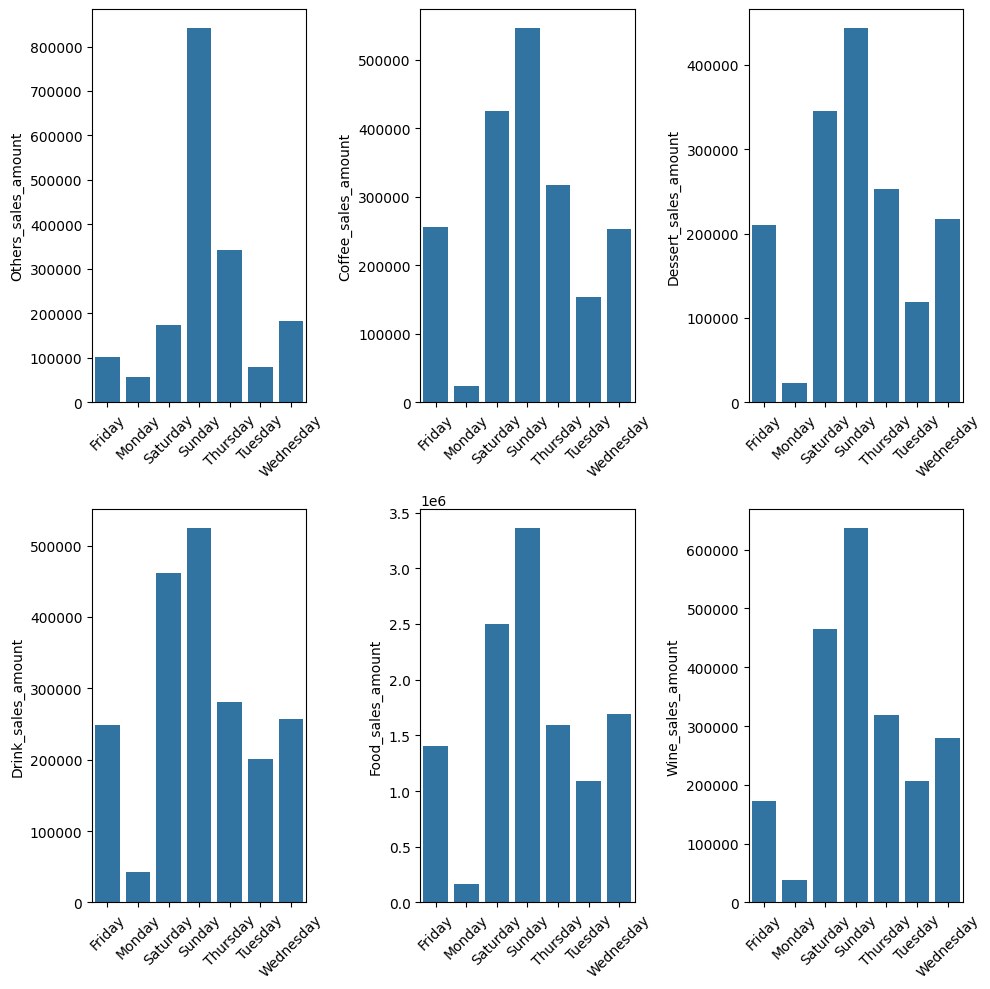

In [212]:
fig, axs = plt.subplots(2, 3, figsize=(10, 10))
categories = ['Others', 'Coffee', 'Dessert', 'Drink', 'Food', 'Wine']
#インデックスとカテゴリを取り出す
for i, category in enumerate(categories):
    row = i // 3
    col = i % 3
    sns.barplot(x='曜日', y=category, data=weekly_category_sales_df.loc[category].reset_index(), ax=axs[row, col])
    axs[row, col].set_xlabel('')
    axs[row, col].set_ylabel(english_labels[i] + '_sales_amount')
    axs[row, col].set_xticks(axs[row, col].get_xticks())
    axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

**カテゴリ別注文率の曜日別傾向**

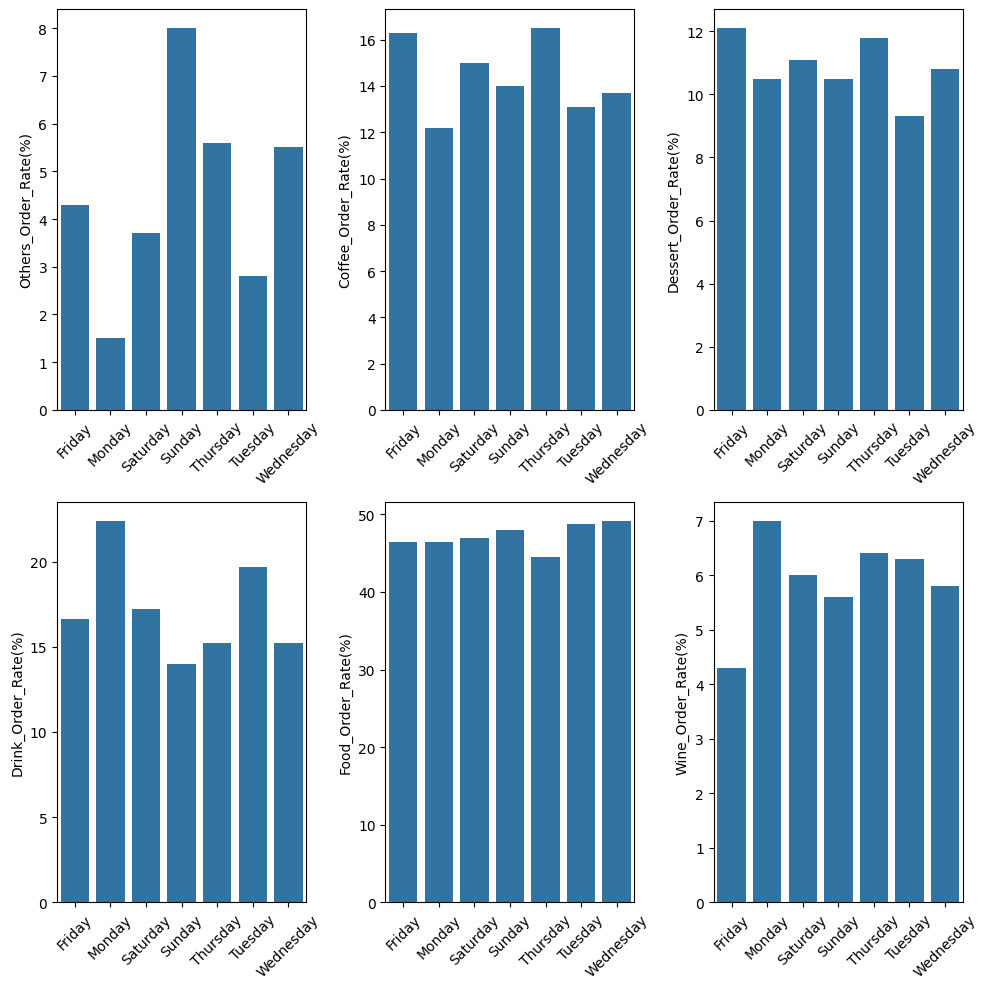

In [213]:
categories = ['Others', 'Coffee', 'Dessert', 'Drink', 'Food', 'Wine']
fig, axs = plt.subplots(2, 3, figsize=(10, 10))
for i, category in enumerate(categories):
    row = i // 3
    col = i % 3
    sns.barplot(x='曜日', y=category, data=result_weekly_rate_category_df[category].reset_index(), ax=axs[row, col])
    axs[row, col].set_xlabel('')
    axs[row, col].set_ylabel(categories[i] + '_Order_Rate(%)')
    axs[row, col].set_xticks(axs[row, col].get_xticks())
    axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()